<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Iron_Ore_Froth_Flotation_Quality_Prediction(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Quality Prediction of Iron Ore Mining Flotation Process**

##**1. Problem Definition**

**Gangue concentrate predict in the reverse cationic flotation:**


Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (e.g. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. **The reverse cationic flotation** is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

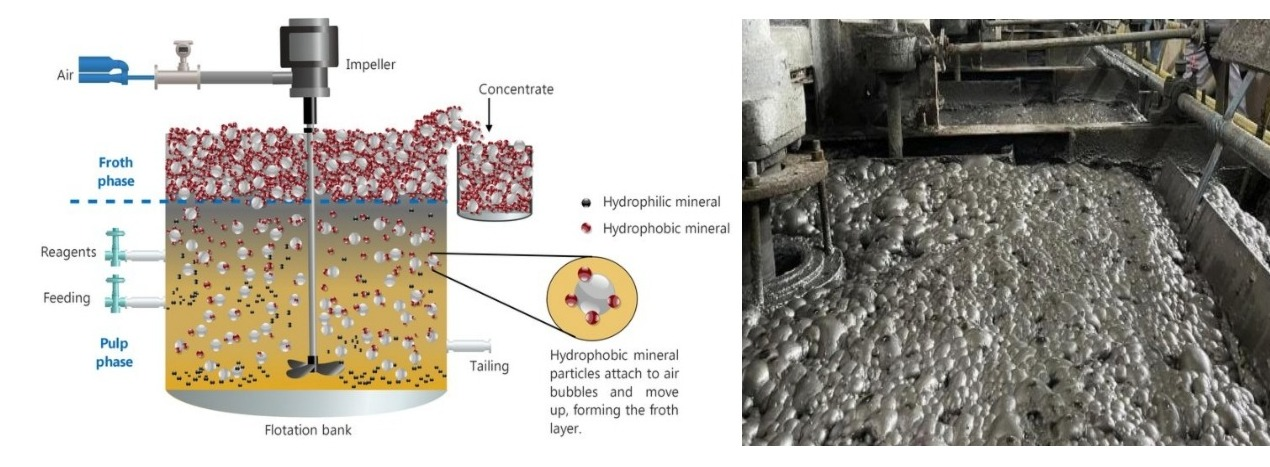

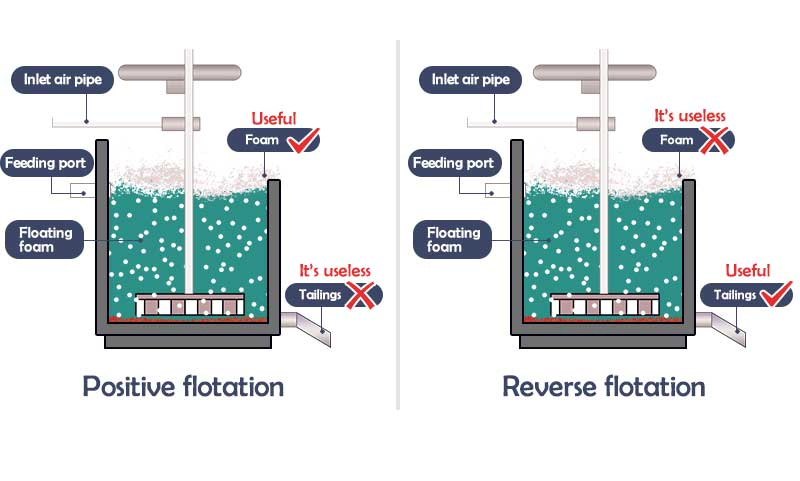

Flotation concentrate is periodically sampled to determine its purity (i.e., *%valuable*, *%gangue*). Higher *%gangue* in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This project explores the application of machine learning to predict gangue (*%silica*) in the flotation concentrate. The prediction will help process engineers assess purity of flotation concentrate and take corrective actions in advance. More specifically, the goal is to tackle the following task:
- **To predict the last column (dependent variable), which is the % of silica in the iron ore concentrate.**

##**2. Data Understanding**

###**2.1. Data Definitions**

- **Date**: Data collection time.
- **% Iron Feed**: Feed grade of iron-containing ore.
- **% Silica Feed**: Feed grade of silica-containing ore.
- **Starch Flow**: Depressant chemical for Iron(Fe) containing ore measured in m³/h.
- **Amina Flow**: Collector chemical for Silica containing ore measured in m³/h.
- **Ore Pulp Flow**: The amount of pulp flow fed to the flotation columns as the product of the previous process step measured in t/h.
- **Ore Pulp pH**: pH is measured in pH scale.
- **Ore Pulp Density**: The solid percent of ore fed density ranges in kg/cm³
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Air Flow**: Air Flows that goes into the flotation cell measured in Nm³/h.
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Level**: Froth level in the flotation cell measured in mm.
- **% Iron Concentrate**: Concentrate grade of iron-containing ore in percentage.
- **% Silica Concentrate**: Concentrate grade of silica-containing ore in percentage

###**2.2. Inspection of the data**

- The first column shows time and date range (march 2017 -  september 2017). 
- Some columns were sampled every 20 second. Others were sampled on a hourly base.
- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant. 
- From Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process. 
- From column 9 until column 22, we can see process data (froth level and air flow inside the flotation columns, which also impact in ore quality). 
- The last two columns are the final iron ore pulp quality measurement from the lab. 

##**3. Data Collection**

###**3.1. Import Libraries and Modules**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

###**3.2. Import Dataset**

In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('flotation1.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [4]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2    
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)    
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

In [5]:
flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 64.70 Mb (50.0% reduction)


- Memory usage decrased from 135.0+ MB to 70.33 MB

In [8]:
flotation.head().T

0         1         2         3         4
iron_feed     0.540799  0.540799  0.540799  0.540799  0.540799
silica_feed   0.288772  0.288772  0.288772  0.288772  0.288772
starch_flow   0.479273  0.480047  0.483071  0.483690  0.481520
amina_flow    0.336160  0.339974  0.342328  0.342678  0.336592
pulp_flow     0.278029  0.292426  0.310805  0.297033  0.315293
pulp_pH       0.337563  0.337677  0.337790  0.337918  0.338031
pulp_density  0.343688  0.343688  0.343688  0.343688  0.343688
airflow_col1  0.242602  0.243706  0.243754  0.244138  0.244760
airflow_col2  0.249972  0.244225  0.238443  0.252590  0.247651
airflow_col3  0.252356  0.252991  0.251770  0.251180  0.250836
airflow_col4  0.212124  0.212124  0.212124  0.212124  0.212124
airflow_col5  0.389071  0.389071  0.389071  0.389071  0.389071
airflow_col6  0.333166  0.332680  0.339354  0.334254  0.331829
airflow_col7  0.349737  0.339555  0.334583  0.351154  0.339200
level_col1    0.267659  0.264605  0.264242  0.264912  0.264912
level_col2    0.237287  0.234832  0.261873  0.254766  0.251214
level_col3    0.251639  0.256003  0.256907  0.261324  0.265352
level_col4    0.307688  0.310574  0.311586  0.309382  0.314083
level_col5    0.343340  0.340028  0.333152  0.325425  0.320033
level_col6    0.305024  0.304746  0.305924  0.299588  0.303354
level_col7    0.359493  0.345292  0.321081  0.300168  0.298754
iron_conc     0.383700  0.383700  0.383700  0.383700  0.383700
silica_conc   0.118877  0.118877  0.118877  0.118877  0.118877

In [9]:
flotation.shape

(737453, 23)

###**5. Exploratory Data Analysis**

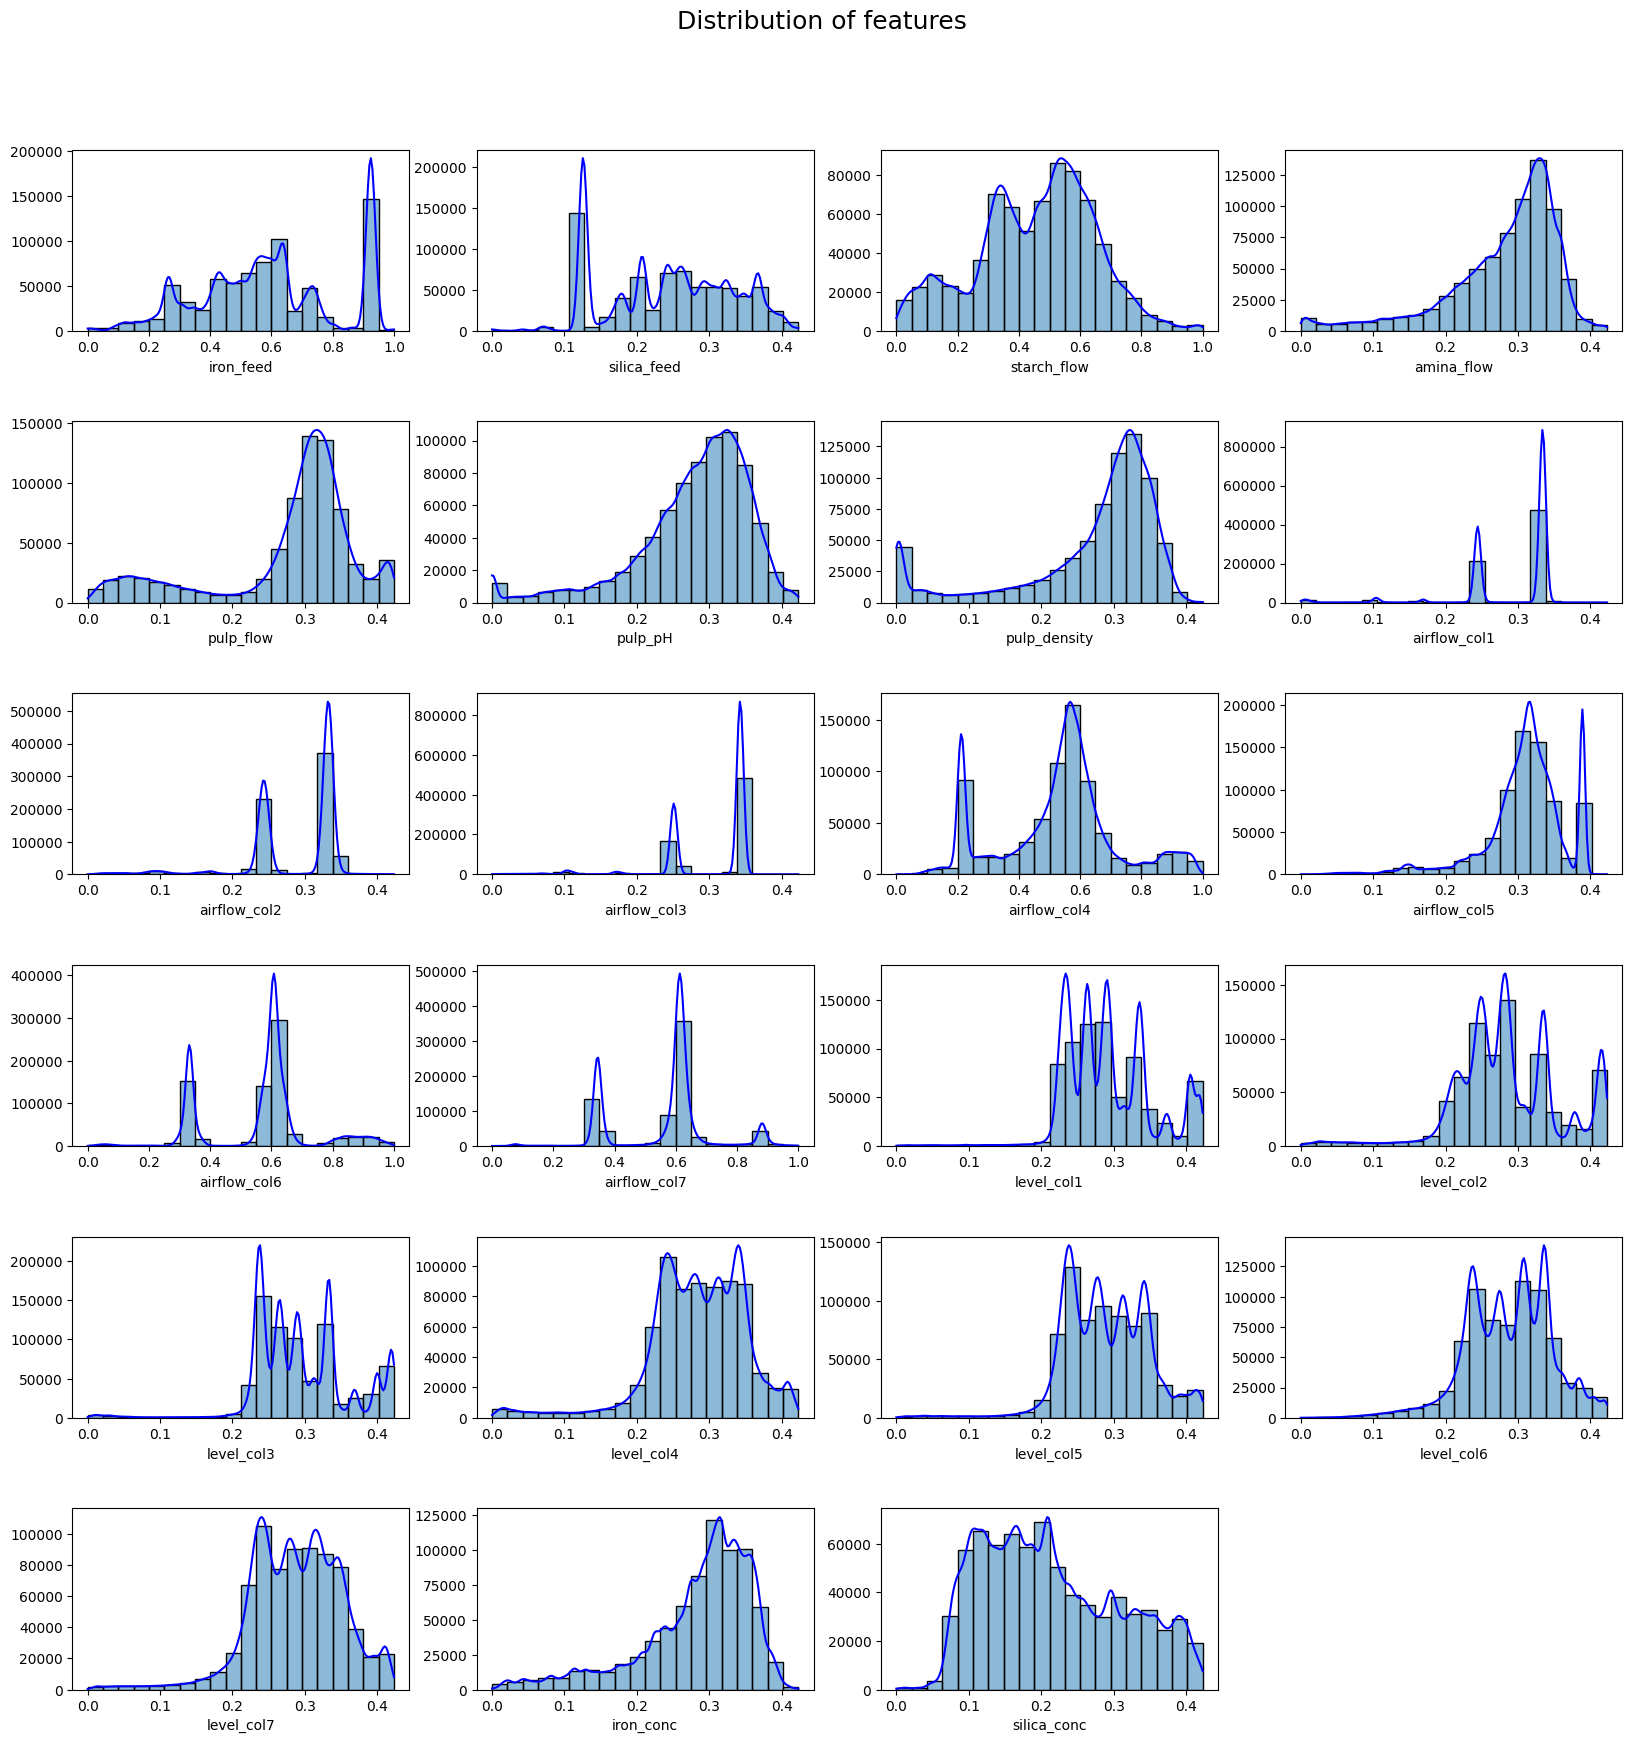

In [6]:
# histogram of the features
features = flotation.columns
plt.figure(figsize= (20,20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution of features", fontsize=18, y=0.95)
for i, feature in enumerate(features):
 k = i + 1
 plt.subplot(6,4,int(k))
 sns.histplot(data=flotation, x=feature, kde=True, bins = 20).lines[0].set_color('blue')
 plt.xlabel(feature)
 plt.ylabel("")
plt.show()

###**4.4. Check skewness**

In [10]:
import pandas as pd
import numpy as np

def calculate_skewness(data):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    skewness = (1/n) * np.sum((data - mean)**3) / std**3
    return skewness


# Selecting the variables for skewness calculation
variables = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", "pulp_flow",
             "pulp_pH", "pulp_density", "airflow_col1", "airflow_col2", "airflow_col3",
             "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", "level_col1",
             "level_col2", "level_col3", "level_col4", "level_col5", "level_col6",
             "level_col7", "iron_conc", "silica_conc"]

# Calculate skewness for each variable
skewness_results = {}
for variable in variables:
    data = flotation[variable].values
    skewness = calculate_skewness(data)
    skewness_results[variable] = skewness

# Print the skewness results
for variable, skewness in skewness_results.items():
    print("Skewness for", variable, ":", skewness)


Skewness for iron_feed : 0.00041304696792240475
Skewness for silica_feed : -0.07341239282686925
Skewness for starch_flow : -0.24258915159667213
Skewness for amina_flow : -1.4110493426993385
Skewness for pulp_flow : -1.254827349813377
Skewness for pulp_pH : -1.3117022385616932
Skewness for pulp_density : -1.5451618388136434
Skewness for airflow_col1 : -2.147131604341639
Skewness for airflow_col2 : -1.593717157350359
Skewness for airflow_col3 : -1.907018338146352
Skewness for airflow_col4 : -0.05012623656558369
Skewness for airflow_col5 : -1.3507300459813691
Skewness for airflow_col6 : -0.11556223504540256
Skewness for airflow_col7 : -0.20868515032924473
Skewness for level_col1 : 0.23152953253292208
Skewness for level_col2 : -0.3107896032842812
Skewness for level_col3 : -0.18914444979089004
Skewness for level_col4 : -1.0590769773688395
Skewness for level_col5 : -0.3587198589581228
Skewness for level_col6 : -0.37436969796344266
Skewness for level_col7 : -0.6019459923970844
Skewness for ir

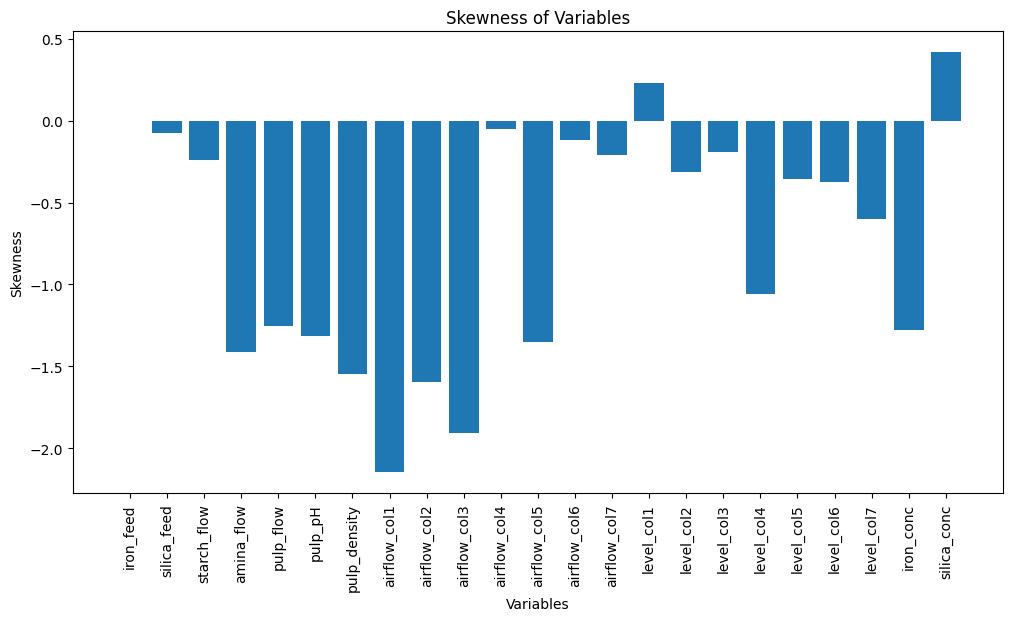

In [11]:
import matplotlib.pyplot as plt

# Extract variable names and skewness values
variable_names = list(skewness_results.keys())
skewness_values = list(skewness_results.values())

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(variable_names, skewness_values)
plt.xlabel("Variables")
plt.ylabel("Skewness")
plt.title("Skewness of Variables")
plt.xticks(rotation=90)
plt.show()


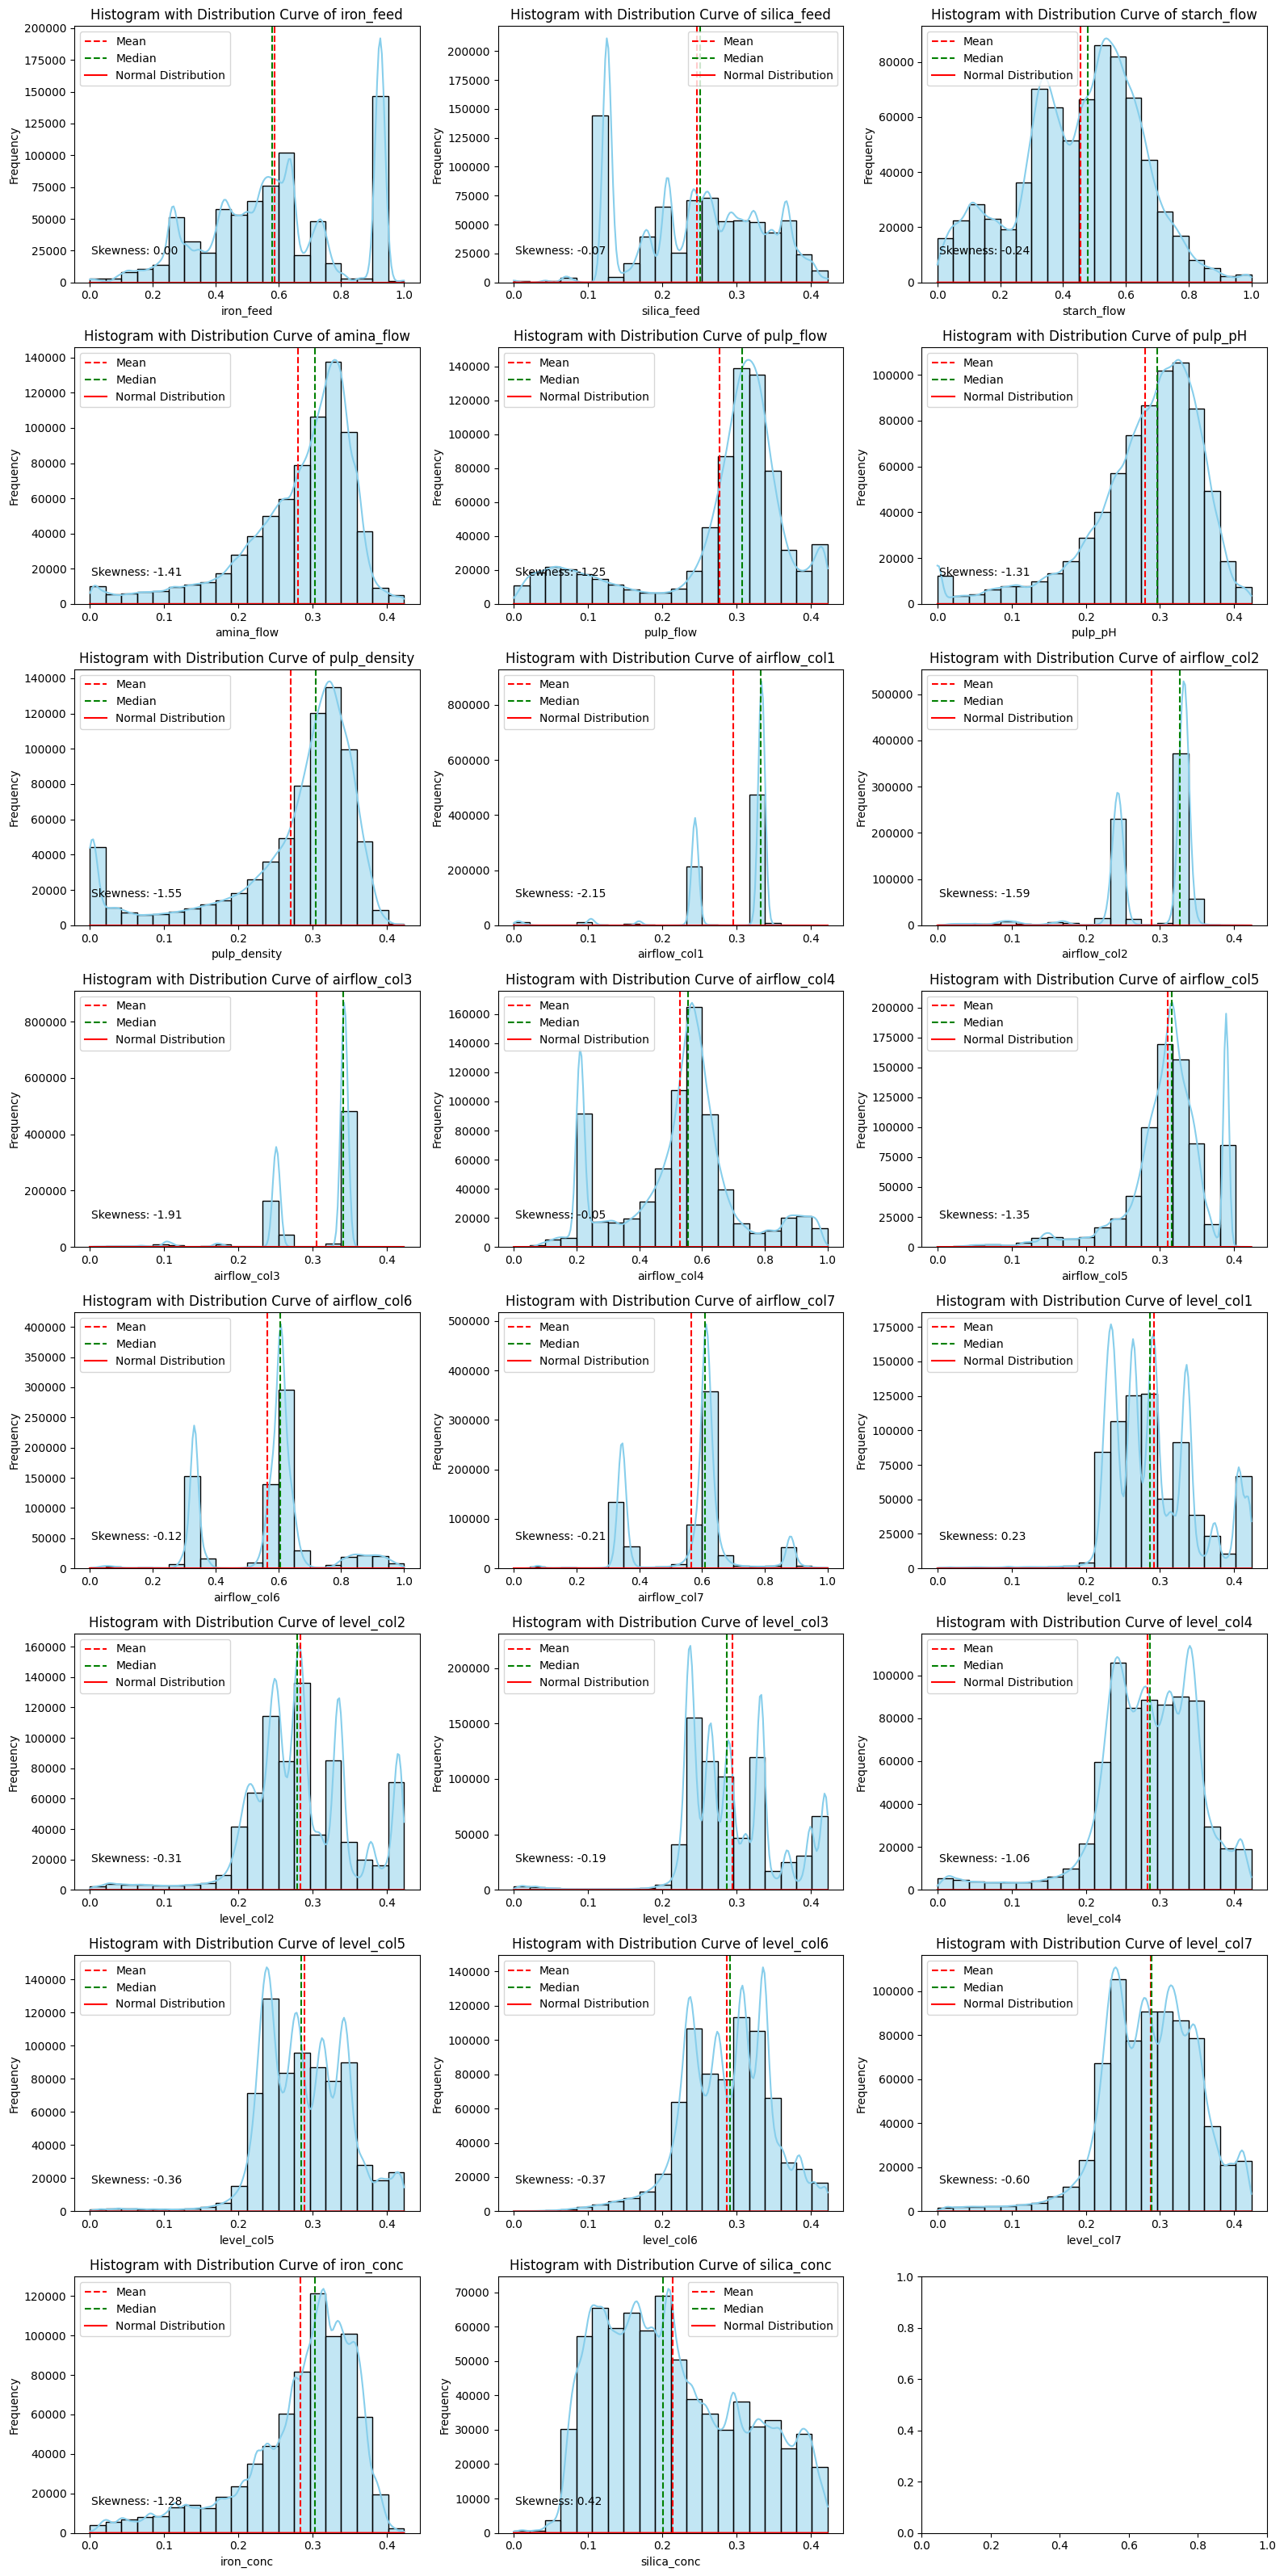

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm

# Selecting the variables for histogram plotting
variables = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", "pulp_flow",
             "pulp_pH", "pulp_density", "airflow_col1", "airflow_col2", "airflow_col3",
             "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", "level_col1",
             "level_col2", "level_col3", "level_col4", "level_col5", "level_col6",
             "level_col7", "iron_conc", "silica_conc"]

# Determine the number of rows and columns for subplots
num_variables = len(variables)
num_rows = (num_variables + 2) // 3  # Round up to the nearest integer

fig, axes = plt.subplots(num_rows, 3, figsize=(16, num_rows * 4))

# Iterate over variables and plot histograms with distribution curve
for i, variable in enumerate(variables):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Plot histogram
    sns.histplot(flotation[variable], kde=True, bins=20, color='skyblue', ax=ax)
    
    # Add a line representing the skewness
    skewness = skew(flotation[variable])
    ax.axvline(x=flotation[variable].mean(), color='r', linestyle='--', label='Mean')
    ax.axvline(x=flotation[variable].median(), color='g', linestyle='--', label='Median')
    
    # Add distribution curve
    x = np.linspace(flotation[variable].min(), flotation[variable].max(), 100)
    mu, sigma = norm.fit(flotation[variable])
    y = norm.pdf(x, mu, sigma)
    ax.plot(x, y, 'r-', label='Normal Distribution')
    
    # Display the degree of skewness
    ax.text(0.05, 0.1, f"Skewness: {skewness:.2f}", transform=ax.transAxes, ha='left', va='bottom')
    
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram with Distribution Curve of ' + variable)
    ax.legend()

fig.tight_layout()
plt.show()


Some variables are very low skewness degree. No need to transform below variables:
- Skewness for iron_feed : 0.00041304696792240475
- Skewness for starch_flow : -0.24258915159667213
- Skewness for airflow_col4 : -0.05012623656558369
- Skewness for airflow_col6 : -0.11556223504540256
- Skewness for airflow_col7 : -0.20868515032924473
- Skewness for level_col4 : 0.09900997598685346

- To normalize skewed variables, we will use Logarithmic Transformation

In [13]:
# Selecting the skewed variables for normalization
skewed_variables = ["silica_feed", "amina_flow", "pulp_flow", "pulp_pH", "pulp_density", 
                         "airflow_col1", "airflow_col2", "airflow_col3", "airflow_col5", 
                         "level_col1", "level_col2", "level_col3", "level_col4", "level_col5", 
                         "level_col6", "level_col7", "iron_conc", "silica_conc"]

# Apply logarithmic transformation to skewed variables
for variable in skewed_variables:
    flotation[variable] = np.log(flotation[variable] + 1)  # Adding 1 to avoid taking log of zero or negative values

- Plot the distributions after transformation

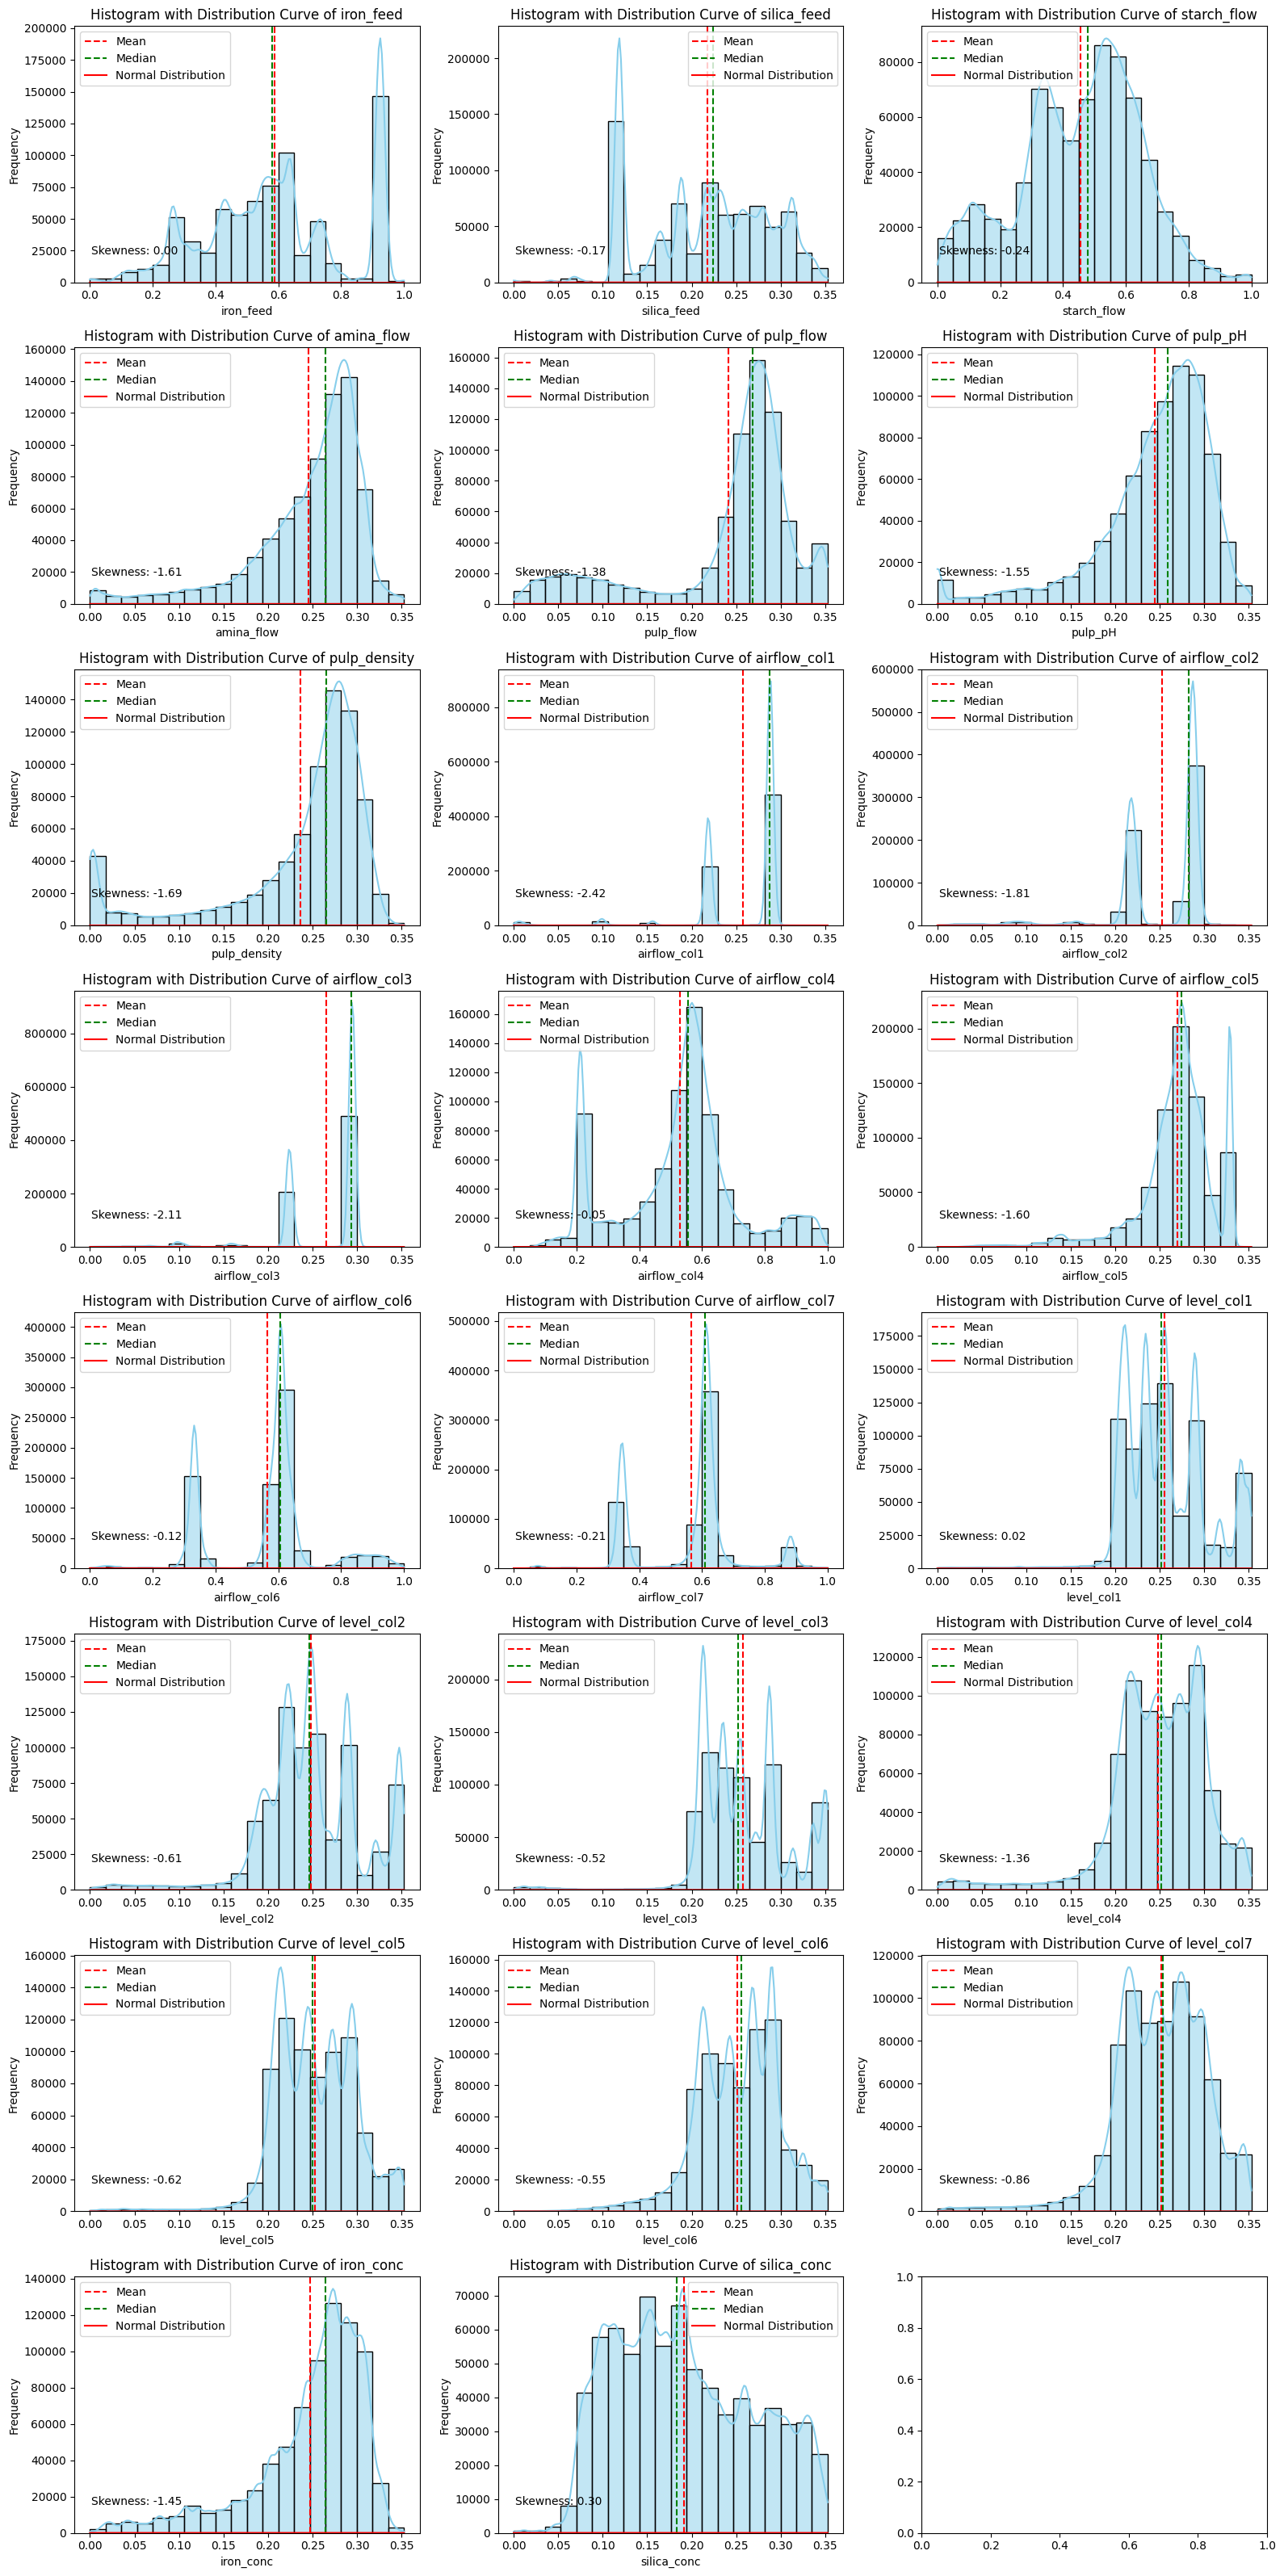

In [14]:
# Selecting the variables for histogram plotting
variables = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", "pulp_flow",
             "pulp_pH", "pulp_density", "airflow_col1", "airflow_col2", "airflow_col3",
             "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", "level_col1",
             "level_col2", "level_col3", "level_col4", "level_col5", "level_col6",
             "level_col7", "iron_conc", "silica_conc"]

# Determine the number of rows and columns for subplots
num_variables = len(variables)
num_rows = (num_variables + 2) // 3  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(16, num_rows * 4))

# Iterate over variables and plot histograms with distribution curve
for i, variable in enumerate(variables):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Plot histogram
    sns.histplot(flotation[variable], kde=True, bins=20, color='skyblue', ax=ax)
    
    # Add a line representing the skewness
    skewness = skew(flotation[variable])
    ax.axvline(x=flotation[variable].mean(), color='r', linestyle='--', label='Mean')
    ax.axvline(x=flotation[variable].median(), color='g', linestyle='--', label='Median')
    
    # Add distribution curve
    x = np.linspace(flotation[variable].min(), flotation[variable].max(), 100)
    mu, sigma = norm.fit(flotation[variable])
    y = norm.pdf(x, mu, sigma)
    ax.plot(x, y, 'r-', label='Normal Distribution')
    
    # Display the degree of skewness
    ax.text(0.05, 0.1, f"Skewness: {skewness:.2f}", transform=ax.transAxes, ha='left', va='bottom')
    
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram with Distribution Curve of ' + variable)
    ax.legend()

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


###**4.5. Corellation between the variables**

In [18]:
# Calculate the correlation matrix
correlation_matrix = flotation.corr()
correlation_matrix

iron_feed  silica_feed  starch_flow  amina_flow  pulp_flow  \
iron_feed      1.000000    -0.979129     0.027981   -0.066034   0.198400   
silica_feed   -0.979129     1.000000    -0.035531    0.064915  -0.177906   
starch_flow    0.027981    -0.035531     1.000000    0.267118   0.029635   
amina_flow    -0.066034     0.064915     0.267118    1.000000   0.175905   
pulp_flow      0.198400    -0.177906     0.029635    0.175905   1.000000   
pulp_pH        0.019422    -0.014724     0.228170    0.147221   0.177202   
pulp_density  -0.096435     0.096507     0.271352    0.704269   0.000406   
airflow_col1  -0.048338     0.033470     0.210772    0.122199  -0.147991   
airflow_col2  -0.149572     0.132625     0.204218    0.126799  -0.143373   
airflow_col3  -0.059734     0.039618     0.198019    0.099102  -0.164719   
airflow_col4  -0.137413     0.120565     0.093520    0.015042  -0.203624   
airflow_col5   0.110043    -0.102509    -0.071420   -0.033555   0.194140   
airflow_col6  -0.042531     0.037750     0.215780    0.118536  -0.225986   
airflow_col7  -0.016356     0.009452     0.194786    0.078240  -0.196451   
level_col1     0.038053    -0.019527    -0.261835   -0.245378   0.006091   
level_col2     0.019891    -0.013912    -0.224797   -0.198786  -0.030793   
level_col3     0.009271    -0.004031    -0.263326   -0.248954  -0.044197   
level_col4     0.015814    -0.032134     0.018708   -0.115874   0.016109   
level_col5     0.034041    -0.051467    -0.036104   -0.170194   0.048359   
level_col6     0.020553    -0.032935    -0.052772   -0.180498   0.009677   
level_col7     0.031588    -0.050660    -0.016127   -0.125544   0.055130   
iron_conc      0.057283    -0.063683     0.062802   -0.090638   0.091587   
silica_conc   -0.072892     0.087372    -0.067096    0.146867   0.011011   

               pulp_pH  pulp_density  airflow_col1  airflow_col2  \
iron_feed     0.019422     -0.096435     -0.048338     -0.149572   
silica_feed  -0.014724      0.096507      0.033470      0.132625   
starch_flow   0.228170      0.271352      0.210772      0.204218   
amina_flow    0.147221      0.704269      0.122199      0.126799   
pulp_flow     0.177202      0.000406     -0.147991     -0.143373   
pulp_pH       1.000000      0.160602      0.157986      0.121284   
pulp_density  0.160602      1.000000      0.091410      0.094435   
airflow_col1  0.157986      0.091410      1.000000      0.872366   
airflow_col2  0.121284      0.094435      0.872366      1.000000   
airflow_col3  0.166457      0.048110      0.944916      0.881233   
airflow_col4  0.135072     -0.041336      0.441396      0.426916   
airflow_col5 -0.102525      0.000123     -0.099628     -0.101593   
airflow_col6  0.082017      0.035300      0.629136      0.580194   
airflow_col7  0.146728      0.011431      0.609490      0.567933   
level_col1   -0.112210     -0.129275     -0.420793     -0.415268   
level_col2   -0.103658     -0.097406     -0.365192     -0.363122   
level_col3   -0.080504     -0.144928     -0.338443     -0.336392   
level_col4    0.073584     -0.038321     -0.065064     -0.067727   
level_col5    0.003749     -0.114296     -0.111995     -0.117137   
level_col6   -0.064878     -0.092426     -0.137449     -0.131996   
level_col7    0.012425     -0.054417     -0.116874     -0.109914   
iron_conc     0.170267      0.019122      0.101163      0.061311   
silica_conc  -0.144636      0.035049     -0.217249     -0.169220   

              airflow_col3  ...  airflow_col7  level_col1  level_col2  \
iron_feed        -0.059734  ...     -0.016356    0.038053    0.019891   
silica_feed       0.039618  ...      0.009452   -0.019527   -0.013912   
starch_flow       0.198019  ...      0.194786   -0.261835   -0.224797   
amina_flow        0.099102  ...      0.078240   -0.245378   -0.198786   
pulp_flow        -0.164719  ...     -0.196451    0.006091   -0.030793   
pulp_pH           0.166457  ...      0.146728   -0.112210   -0.103658   
pulp_density      0.048110  ...      0.011431

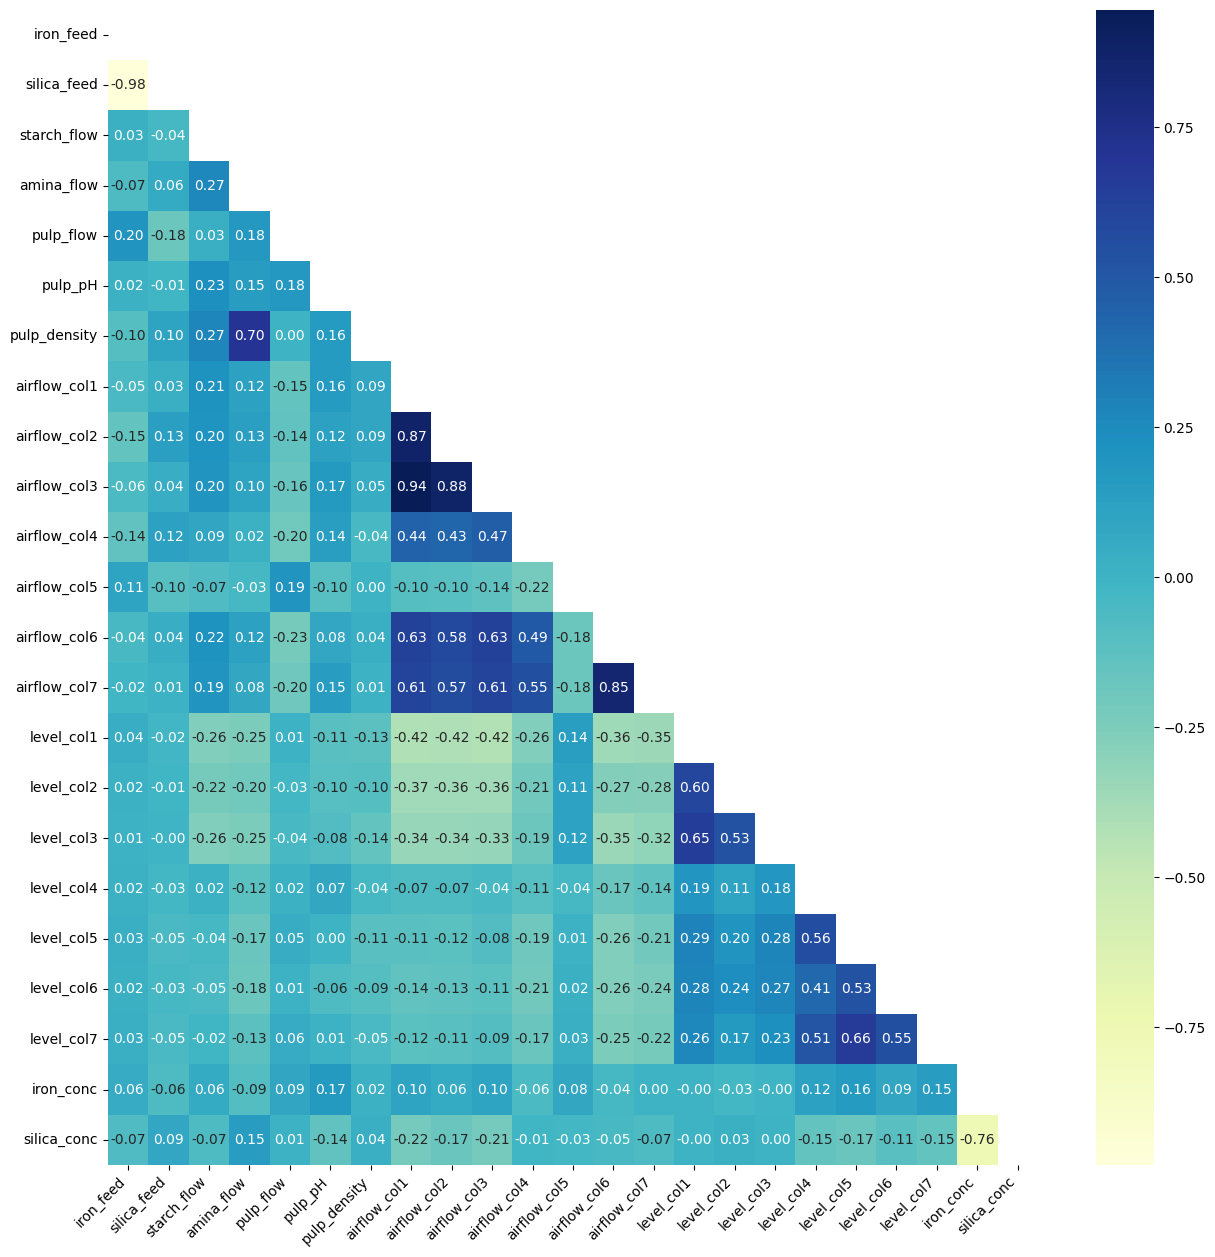

In [19]:
# Plot corellation martix heatmap of variables
fig, ax = plt.subplots(figsize=(15, 15))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, 
            annot=True, fmt=".2f", cmap="YlGnBu")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

###**4.6. Relationship between target variable vs features**

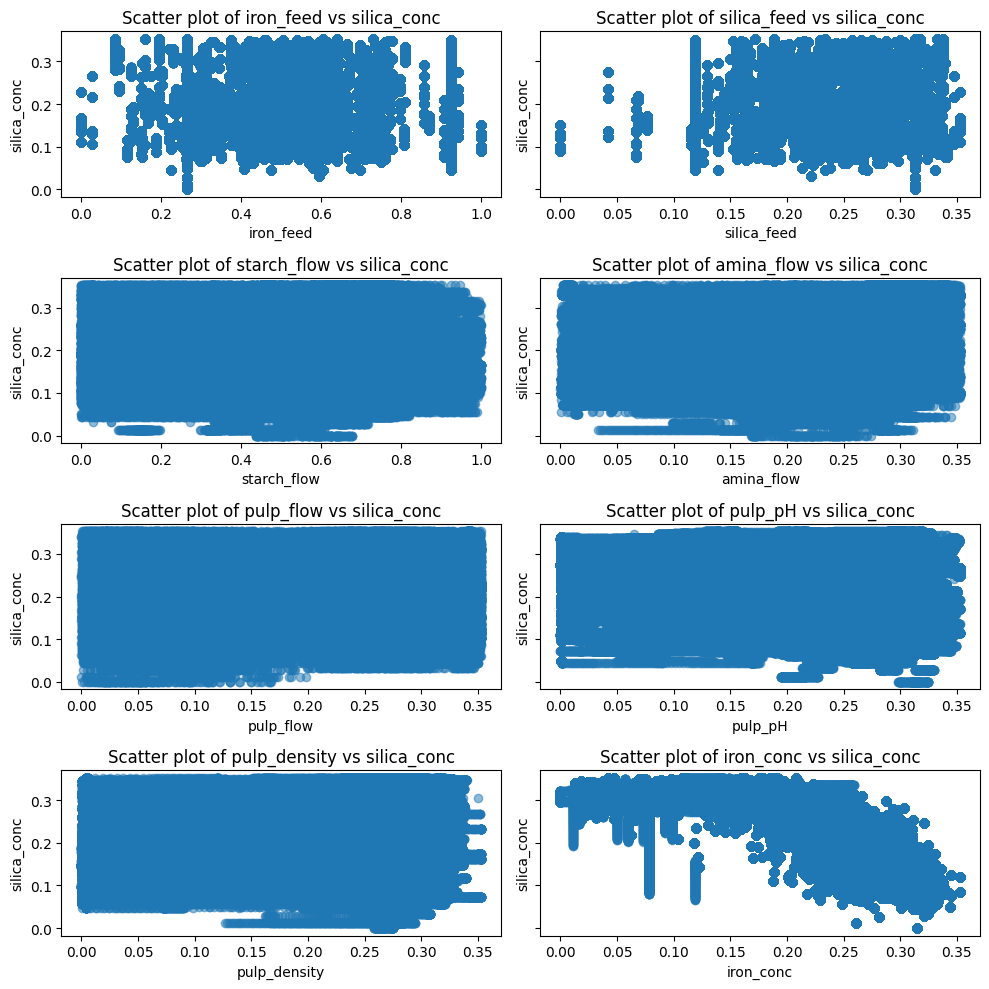

In [20]:
colnames = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", "pulp_flow",
            "pulp_pH", "pulp_density", "iron_conc"]

target = "silica_conc"

# Create subplots for each independent variable
fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharey=True)
axes = axes.flatten()

for i, colname in enumerate(colnames):
    ax = axes[i]
    ax.scatter(flotation[colname], flotation[target], alpha=0.5)
    ax.set_xlabel(colname)
    ax.set_ylabel("silica_conc")
    ax.set_title(f"Scatter plot of {colname} vs silica_conc")

# Remove empty subplots if there are any
if len(colnames) < len(axes):
    for j in range(len(colnames), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

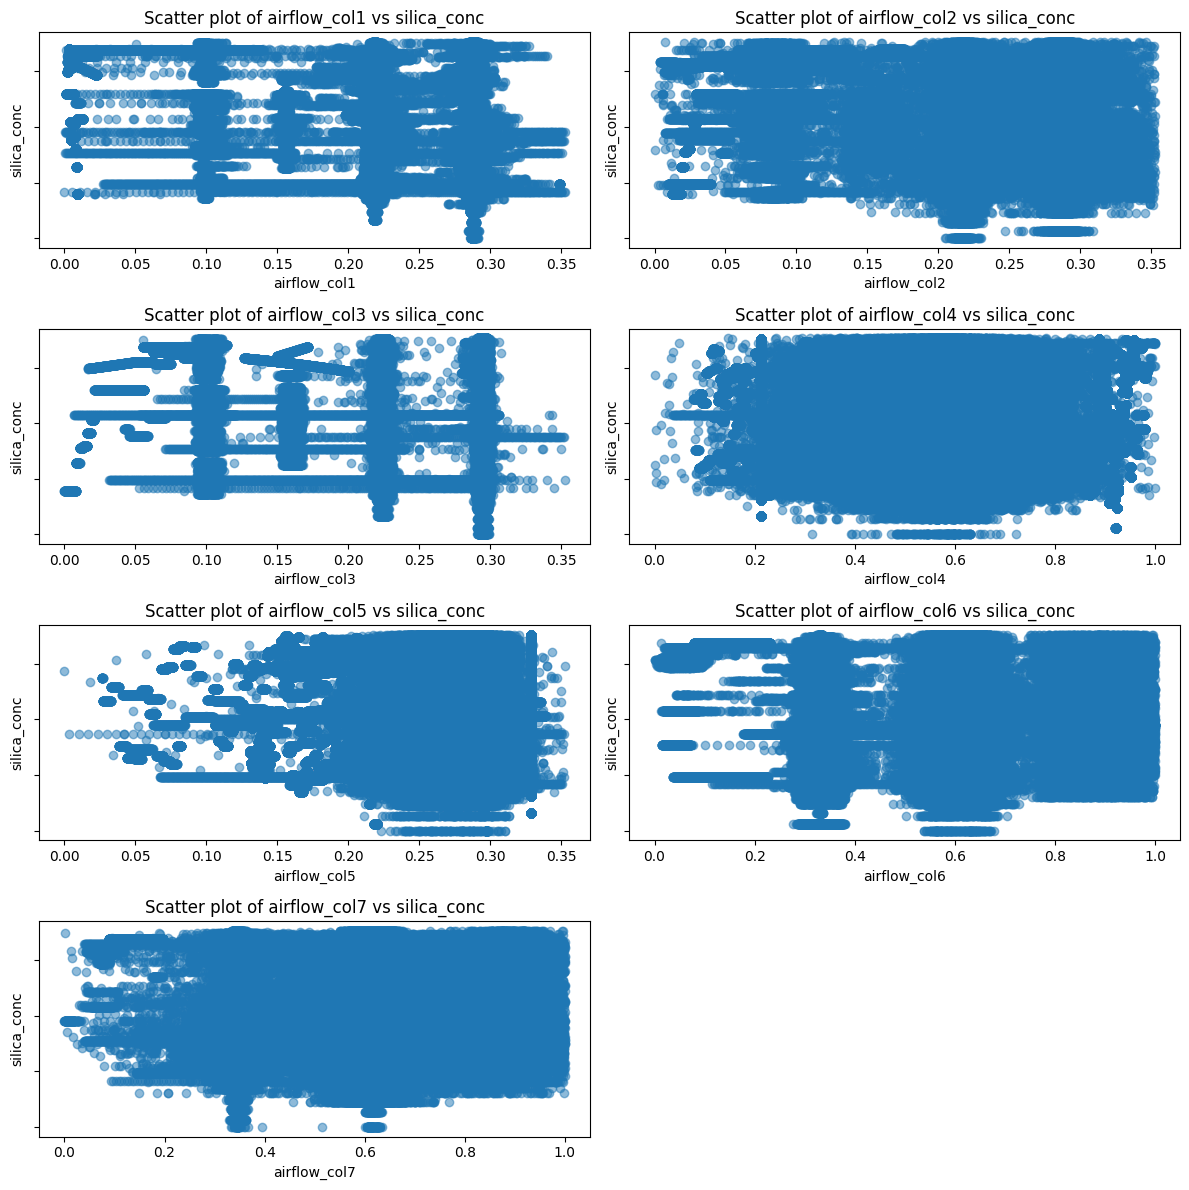

In [21]:
colnames = ["airflow_col1", "airflow_col2", "airflow_col3", 
            "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7"]

target = "silica_conc"

fig, axes = plt.subplots(4, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

# Plot each independent variable separately
for i, colname in enumerate(colnames):
    ax = axes[i]
    ax.scatter(flotation[colname], flotation[target], alpha=0.5)
    ax.set_xlabel(colname)
    ax.set_ylabel("silica_conc")
    ax.set_title(f"Scatter plot of {colname} vs silica_conc")
    ax.set_yticklabels([colname], rotation=45)

if len(colnames) < len(axes):
    for j in range(len(colnames), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

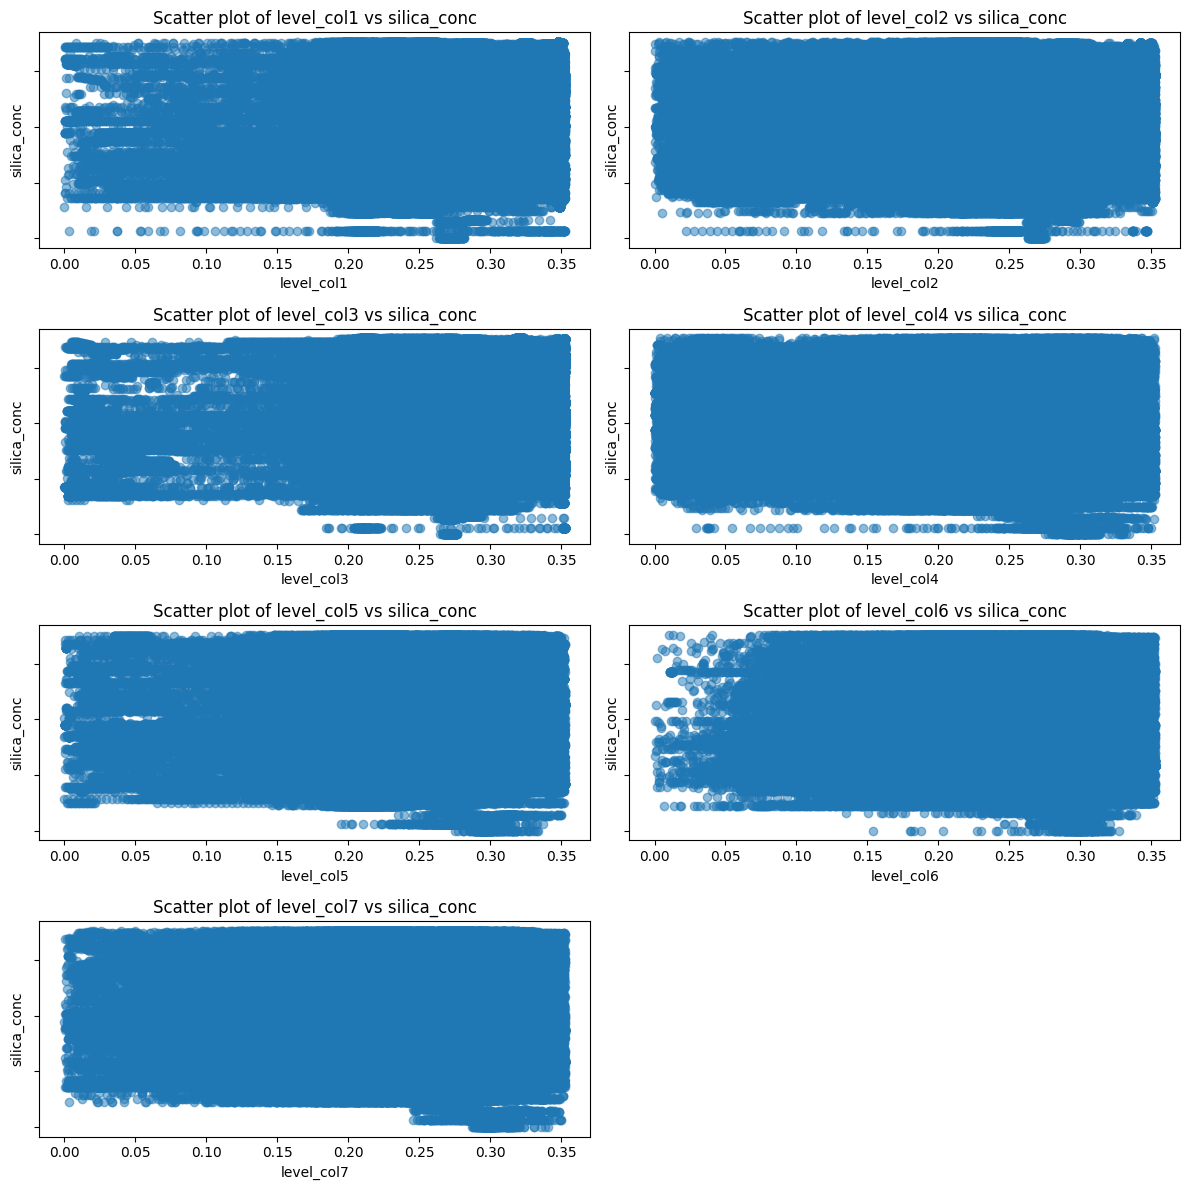

In [22]:
colnames = ["level_col1", "level_col2", "level_col3",
            "level_col4", "level_col5", "level_col6", "level_col7"]

target = "silica_conc"

fig, axes = plt.subplots(4, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

# Plot each independent variable separately
for i, colname in enumerate(colnames):
    ax = axes[i]
    ax.scatter(flotation[colname], flotation[target], alpha=0.5)
    ax.set_xlabel(colname)
    ax.set_ylabel("silica_conc")
    ax.set_title(f"Scatter plot of {colname} vs silica_conc")
    ax.set_yticklabels([colname], rotation=45)

if len(colnames) < len(axes):
    for j in range(len(colnames), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

###**4.8. Check Outliers**

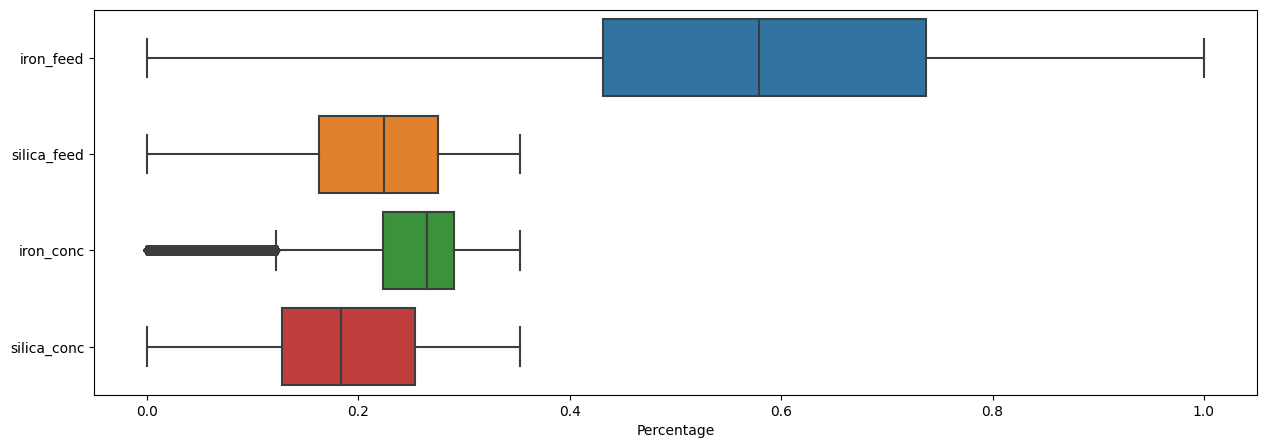

In [23]:
#box plots of input and output values 
plt.figure(figsize = (15, 5))
sns.boxplot(data = flotation[["iron_feed", "silica_feed", "iron_conc", "silica_conc"]], orient = 'h')
plt.xlabel('Percentage');

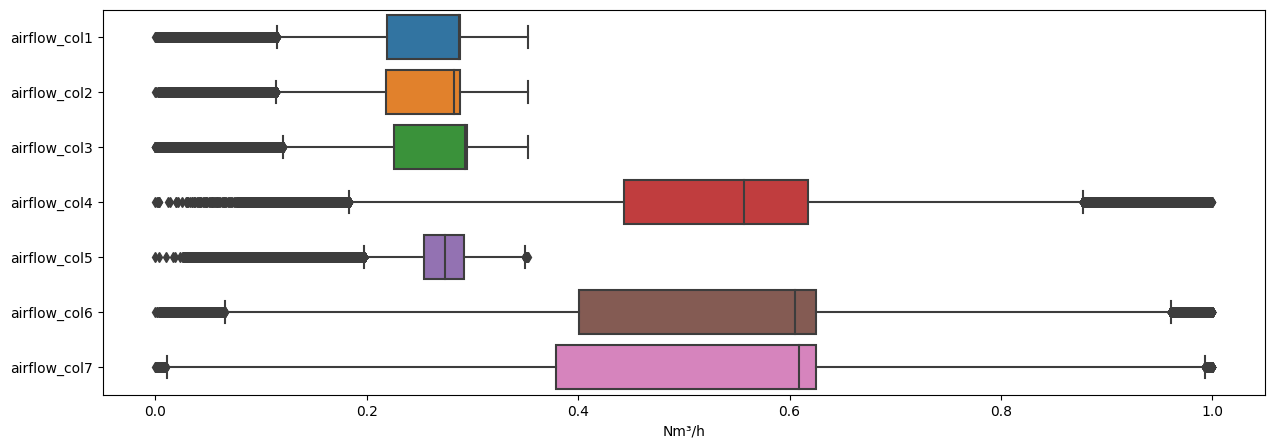

In [24]:
#box plots of airflow values 
plt.figure(figsize = (15, 5))
sns.boxplot(data = flotation[["airflow_col1", "airflow_col2", "airflow_col3", 
                              "airflow_col4", "airflow_col5", "airflow_col6", 
                              "airflow_col7"]], orient = 'h')
plt.xlabel('Nm³/h');

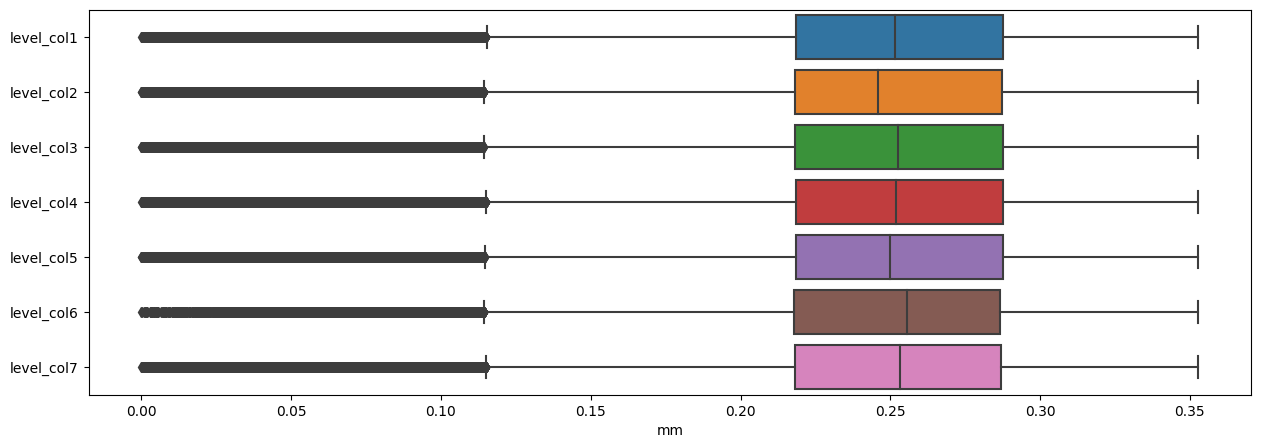

In [25]:
#box plots of froth level values 
plt.figure(figsize = (15, 5))
sns.boxplot(data = flotation[["level_col1", "level_col2", "level_col3", 
                              "level_col4", "level_col5","level_col6", 
                              "level_col7"]], orient = 'h')
plt.xlabel('mm');

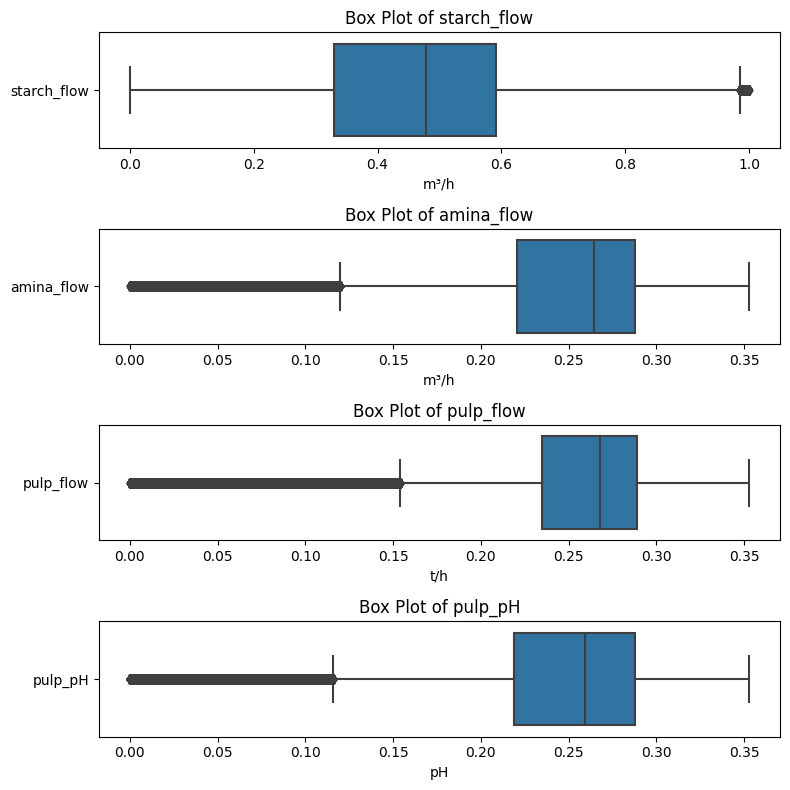

In [36]:
fig, axes = plt.subplots(4, 1, figsize=(8, 8))

# Box plots for starch_flow
sns.boxplot(data=flotation[["starch_flow"]], orient='h', ax=axes[0])
axes[0].set_xlabel('m³/h')
axes[0].set_title('Box Plot of starch_flow')

# Box plots for amina_flow
sns.boxplot(data=flotation[["amina_flow"]], orient='h', ax=axes[1])
axes[1].set_xlabel('m³/h')
axes[1].set_title('Box Plot of amina_flow')

# Box plots for pulp_flow
sns.boxplot(data=flotation[["pulp_flow"]], orient='h', ax=axes[2])
axes[2].set_xlabel('t/h')
axes[2].set_title('Box Plot of pulp_flow')

# Box plots for pulp_pH
sns.boxplot(data=flotation[["pulp_pH"]], orient='h', ax=axes[3])
axes[3].set_xlabel('pH')
axes[3].set_title('Box Plot of pulp_pH')

plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
import numpy as np

# Specify the columns to consider for outlier removal
columns_to_check = ["iron_feed", "silica_feed", "starch_flow",
               "amina_flow", "pulp_flow", "pulp_pH", "pulp_density",
               "airflow_col1", "airflow_col2", "airflow_col3",
               "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", 
               "level_col1", "level_col2", "level_col3", "level_col4", "level_col5", 
               "level_col6", "level_col7",
               "iron_conc", "silica_conc"]

# Loop over each column to identify and eliminate outliers
for column in columns_to_check:
    # Calculate the lower and upper thresholds
    lower_threshold = np.percentile(flotation[column], 25) - 1.5 * (np.percentile(flotation[column], 75) - np.percentile(flotation[column], 25))
    upper_threshold = np.percentile(flotation[column], 75) + 1.5 * (np.percentile(flotation[column], 75) - np.percentile(flotation[column], 25))
    
    # Identify outliers
    outliers = flotation[(flotation[column] < lower_threshold) | (flotation[column] > upper_threshold)]
    
    # Remove outliers
    modified_flotation = flotation[(flotation[column] >= lower_threshold) & (flotation[column] <= upper_threshold)]

In [28]:
modified_flotation.shape

(737453, 23)

Now data points of dataset has decreased from 736282 to 731525

###**4.7. Check Skewness**

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot

def check_skewness(col):
    sns.distplot(flotation[col], fit=norm)
    fig = plt.figure()
    res = probplot(flotation[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(flotation[col])
    print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


 mu = 0.19 and sigma = 0.08



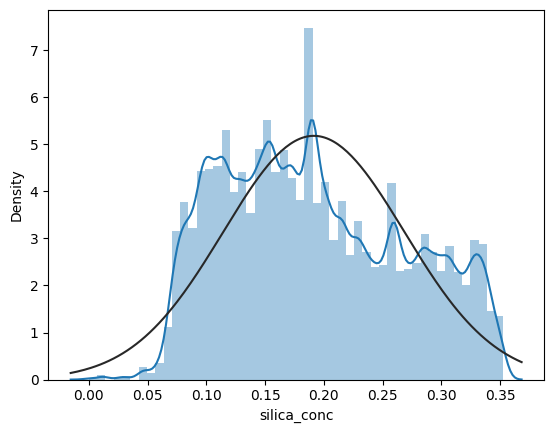

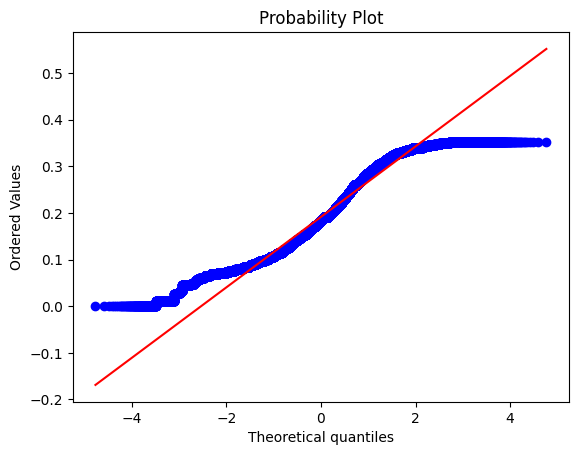

In [30]:
check_skewness("silica_conc")


 mu = 0.22 and sigma = 0.07



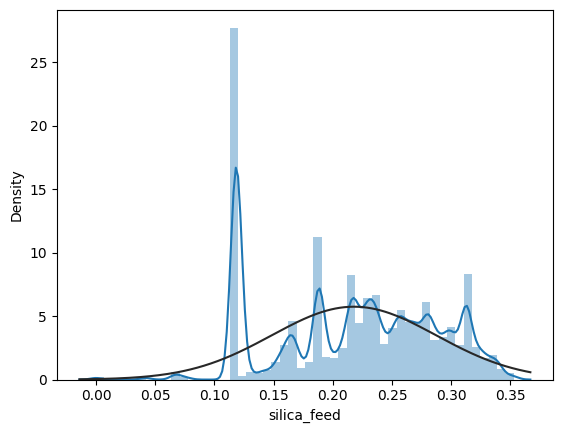

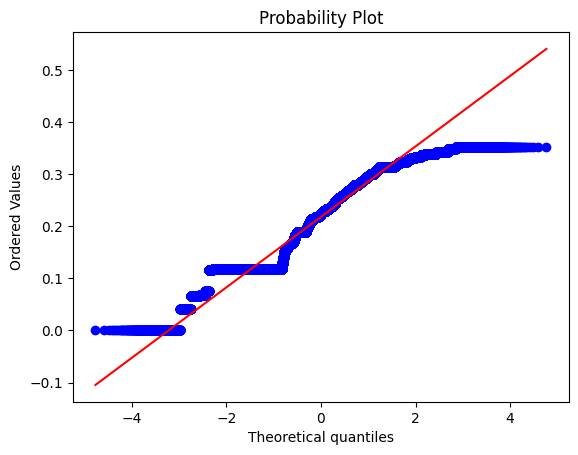

In [31]:
check_skewness("silica_feed")


 mu = 0.46 and sigma = 0.19



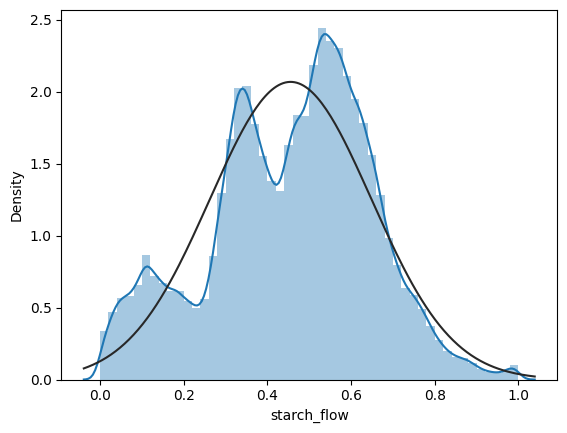

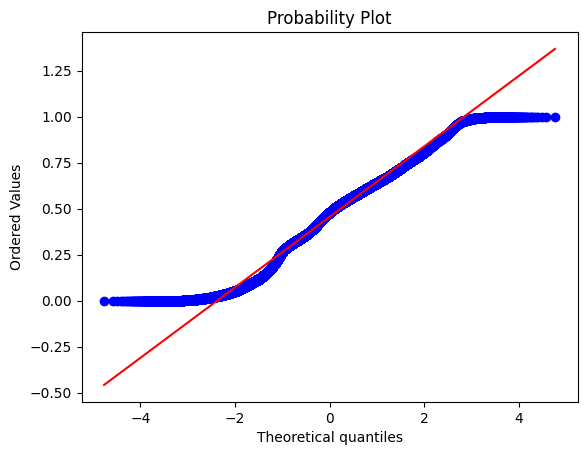

In [32]:
check_skewness("starch_flow")


 mu = 0.26 and sigma = 0.05



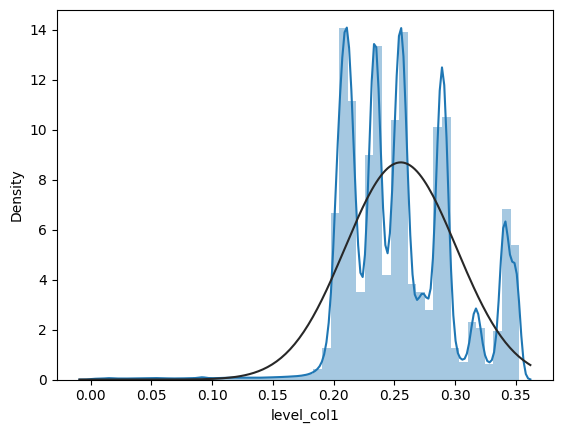

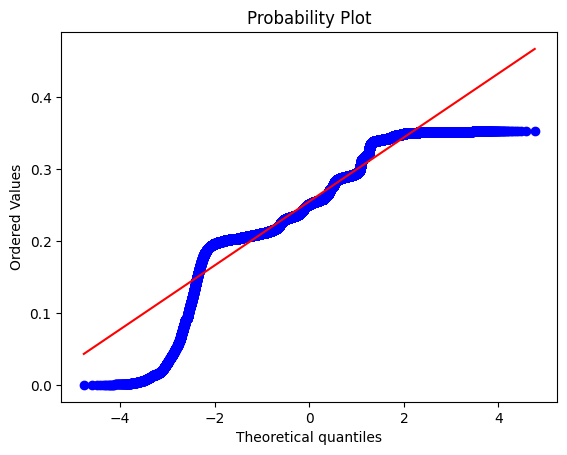

In [33]:
check_skewness("level_col1")


 mu = 0.23 and sigma = 0.04



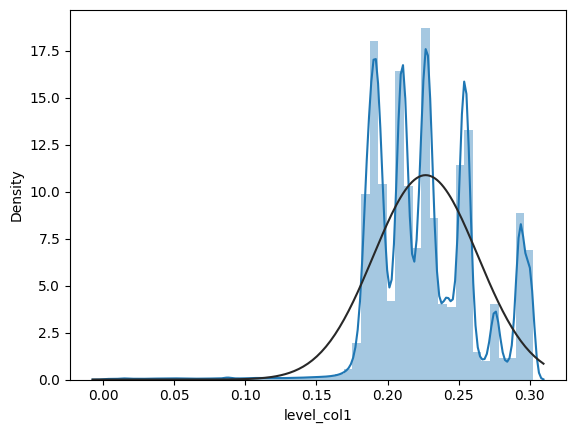

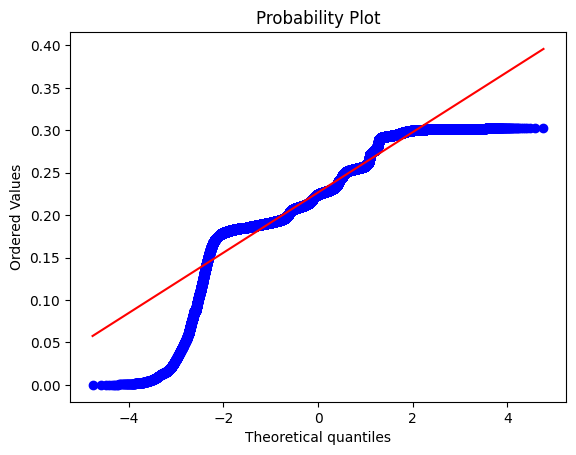

In [34]:
flotation["level_col1"] = np.log1p(flotation["level_col1"])
check_skewness("level_col1")

This distribution is positively skewed. Notice that the black curve is more deviated towards the right. If you encounter that your predictive (response) variable is skewed, it is recommended to fix the skewness to make good decisions by the model.

Okay, So how do I fix the skewness?
The best way to fix it is to perform a log transform of the same data, with the intent to reduce the skewness.


 mu = 0.17 and sigma = 0.06



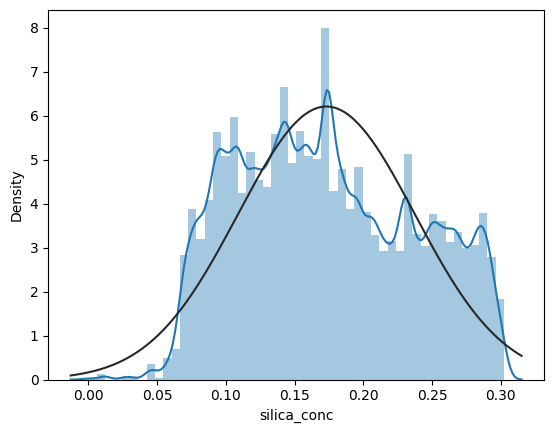

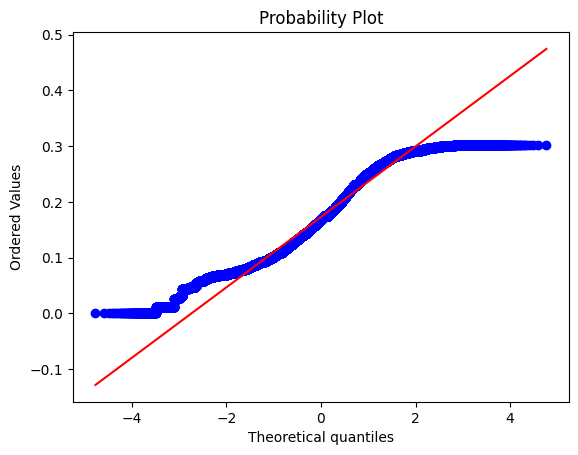

In [35]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
flotation["silica_conc"] = np.log1p(flotation["silica_conc"])
check_skewness("silica_conc")

##**5. Modelling**

##**6. Evaluating**

##**7. Tunning Model**